In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
df_orginal = pd.read_csv('taobao_persona.csv')

## 数据预处理

In [3]:
df_orginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23291027 entries, 0 to 23291026
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 1.0+ GB


数据集太大，为了提高运行效率，随机抽取20%的数据

## 数据抽样


In [4]:
df =df_orginal.sample(frac=0.2,random_state=100)

In [5]:
#回收内存
del df_orginal
gc.collect()

10

## 缺失值处理

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658205 entries, 7945037 to 15635605
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 248.8+ MB


In [7]:
df.shape

(4658205, 6)

In [8]:
#查看各字段的缺失值数量
df.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     3183000
item_category          0
time                   0
dtype: int64

只有user_geohash有缺失值，且缺失的比例很高，无统计分析的意义，将此列删除

In [9]:
df.drop('user_geohash',axis=1,inplace=True)

In [10]:
df.head()

,user_id,item_id,behavior_type,item_category,time
7945037,63995000,345504596,1,94,2014-12-02 19
3482145,141227570,82518209,1,5232,2014-11-28 16
15812704,104574739,119762923,1,10392,2014-11-20 21
16417944,112700668,339260891,1,6000,2014-12-01 12
22276947,53139833,143404263,1,9835,2014-11-20 22


## 日期与时段处理

In [11]:
#将time字段拆分为日期、星期、时段
df['date']=df['time'].str[0:10]
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['week'] = df['date'].apply(lambda x : x.weekday()+1)
df['time'] = df['time'].str[11:]
df['time'] = df['time'].astype(int)

In [12]:
#将时段分为'凌晨'、'上午'、'中午'、'下午'、'晚上'
df['hour'] = pd.cut(df['time'],bins=[-1,5,10,13,18,24],labels=['凌晨','上午','中午','下午','晚上'])

In [13]:
df.head()

,user_id,item_id,behavior_type,item_category,time,date,week,hour
7945037,63995000,345504596,1,94,19,2014-12-02,2,晚上
3482145,141227570,82518209,1,5232,16,2014-11-28,5,下午
15812704,104574739,119762923,1,10392,21,2014-11-20,4,晚上
16417944,112700668,339260891,1,6000,12,2014-12-01,1,中午
22276947,53139833,143404263,1,9835,22,2014-11-20,4,晚上


## 制作用户标签表

In [14]:
#生成用户标签表，制作好的标签都加入这个表中
users = df['user_id'].unique()
labels = pd.DataFrame(users,columns=['user_id'])

## 一、用户行为标签

### 用户浏览活跃时间段

In [15]:
#对用户和时段分组，统计浏览次数
time_browse = df[df['behavior_type']==1].groupby(['user_id','hour']).item_id.count().reset_index()

In [16]:
time_browse.head(10)

,user_id,hour,item_id
0,492,凌晨,0
1,492,上午,6
2,492,中午,8
3,492,下午,8
4,492,晚上,29
5,3726,凌晨,0
6,3726,上午,1
7,3726,中午,11
8,3726,下午,25
9,3726,晚上,41


In [17]:
time_browse.rename(columns={'item_id':'hour_counts'},inplace=True)

In [18]:
#统计每个用户浏览次数最多的时段
time_browse_max = time_browse.groupby('user_id').hour_counts.max().reset_index()

In [19]:
time_browse_max.rename(columns={'hour_counts':'read_counts_max'},inplace=True)

In [20]:
time_browse=pd.merge(time_browse,time_browse_max,how='left',on='user_id')

In [21]:
time_browse.loc[time_browse['hour_counts']==time_browse['read_counts_max'],'hour'].groupby(time_browse['user_id']).aggregate(lambda x:','.join(x))

user_id
492          晚上
3726         晚上
19137        晚上
36465        中午
37101        下午
             ..
142427508    晚上
142432272    晚上
142439559    晚上
142440276    下午
142442955    晚上
Name: hour, Length: 19956, dtype: object

In [22]:
#选取各用户浏览次数最多的时段，如有并列最多的时段，用逗号连接
time_browse_hour = time_browse.loc[time_browse['hour_counts']==time_browse['read_counts_max'],'hour'].groupby(time_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [23]:
time_browse_hour.head()

,user_id,hour
0,492,晚上
1,3726,晚上
2,19137,晚上
3,36465,中午
4,37101,下午


In [24]:
#将用户浏览活跃时间段加入到用户标签表中
labels = pd.merge(labels,time_browse_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_browse'},inplace=True)

In [25]:
labels.head(10)

,user_id,time_browse
0,63995000,晚上
1,141227570,下午
2,104574739,晚上
3,112700668,晚上
4,53139833,晚上
5,101490976,下午
6,120019864,晚上
7,134463810,下午
8,111037423,晚上
9,55358033,下午


In [34]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19960 entries, 0 to 19959
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      19960 non-null  int64 
 1   time_browse  19956 non-null  object
dtypes: int64(1), object(1)
memory usage: 467.8+ KB


### 用户购买活跃时间段

In [37]:
#生成逻辑与浏览活跃时间段相同
time_buy = df[df['behavior_type']==4].groupby(['user_id','hour']).item_id.count().reset_index()
time_buy.rename(columns={'item_id':'hour_counts'},inplace=True)
time_buy_max = time_buy.groupby('user_id').hour_counts.max().reset_index()
time_buy_max.rename(columns={'hour_counts':'buy_counts_max'},inplace=True)
time_buy = pd.merge(time_buy,time_buy_max,how='left',on='user_id')
time_buy_hour = time_buy.loc[time_buy['hour_counts']==time_buy['buy_counts_max'],['hour','user_id']].groupby(time_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [38]:
time_buy_hour.head()

,user_id,hour
0,37101,中午
1,38745,中午
2,45561,"上午,中午"
3,59436,晚上
4,100605,凌晨


In [41]:
#将用户购买活跃时间段加入到用户标签表中
labels = pd.merge(labels,time_buy_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_buy'},inplace=True)

In [44]:
labels.head()

,user_id,time_browse,time_buy
0,63995000,晚上,晚上
1,141227570,下午,上午
2,104574739,晚上,中午
3,112700668,晚上,下午
4,53139833,晚上,"下午,晚上"


In [45]:
del time_browse
del time_buy
del time_browse_hour
del time_browse_max
del time_buy_hour
del time_buy_max
gc.collect()

0

### 用户倾向周几浏览

In [46]:
week_browse=df[df['behavior_type']==1].groupby(['user_id','week']).item_id.count().reset_index()
week_browse.rename(columns={'item_id':'week_counts'},inplace=True)
week_browse_max = week_browse.groupby('user_id').week_counts.max().reset_index()
week_browse_max.rename(columns={'week_counts':'week_counts_max'},inplace=True)
week_browse = pd.merge(week_browse,week_browse_max,how='left',on='user_id')

In [47]:
week_browse['week']=week_browse['week'].astype(str)
week_browse_date=week_browse.loc[week_browse['week_counts']==week_browse['week_counts_max'],'week'].groupby(week_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [48]:
week_browse_date.head(10)

,user_id,week
0,492,7
1,3726,3
2,19137,6
3,36465,"3,5"
4,37101,2
5,38745,3
6,45561,2
7,53394,5
8,59436,5
9,60552,6


In [50]:
#将用户倾向周几浏览段加入到用户标签表中
labels = pd.merge(labels,week_browse_date,how='left',on='user_id')
labels.rename(columns={'week':'week_browse'},inplace=True)

In [51]:
labels.head()

,user_id,time_browse,time_buy,week_browse
0,63995000,晚上,晚上,7
1,141227570,下午,上午,3
2,104574739,晚上,中午,2
3,112700668,晚上,下午,1
4,53139833,晚上,"下午,晚上",7


### 用户倾向周几购买

In [52]:
week_buy=df[df['behavior_type']==4].groupby(['user_id','week']).item_id.count().reset_index()
week_buy.rename(columns={'item_id':'week_counts'},inplace=True)
week_buy_max = week_buy.groupby('user_id').week_counts.max().reset_index()
week_buy_max.rename(columns={'week_counts':'week_counts_max'},inplace=True)
week_buy = pd.merge(week_buy,week_buy_max,how='left',on='user_id')
week_buy['week']=week_buy['week'].astype(str)
week_buy_date=week_buy.loc[week_buy['week_counts']==week_buy['week_counts_max'],'week'].groupby(week_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [53]:
week_buy_date.head(10)

,user_id,week
0,37101,5
1,38745,3
2,45561,"5,6"
3,59436,"4,5"
4,100605,5
5,100890,3
6,106362,2
7,131694,"4,7"
8,134211,1
9,137907,7


In [55]:
#将用户倾向周几购买段加入到用户标签表中
labels = pd.merge(labels,week_buy_date,how='left',on='user_id')
labels.rename(columns={'week':'week_buy'},inplace=True)

In [56]:
labels.head()

,user_id,time_browse,time_buy,week_browse,week_buy
0,63995000,晚上,晚上,7,6
1,141227570,下午,上午,3,3
2,104574739,晚上,中午,2,7
3,112700668,晚上,下午,1,5
4,53139833,晚上,"下午,晚上",7,3


In [57]:
del week_browse
del week_browse_max
del week_buy_max
del week_buy
del week_buy_date
gc.collect()

0

## 关于类目的用户行为

In [58]:
df_browse = df.loc[df['behavior_type']==1,['user_id','item_id','item_category']]
df_collect = df.loc[df['behavior_type']==2,['user_id','item_id','item_category']]
df_cart = df.loc[df['behavior_type']==3,['user_id','item_id','item_category']]
df_buy = df.loc[df['behavior_type']==4,['user_id','item_id','item_category']]

### 浏览最多的类目

In [59]:
#对用户与类目进行分组，统计浏览次数
df_most_cate_browse = df_browse.groupby(['user_id','item_category']).item_id.count().reset_index()

In [60]:
df_most_cate_browse.rename(columns={'item_id':'item_category_counts'},inplace=True)

In [61]:
df_most_cate_browse_max = df_most_cate_browse.groupby('user_id').item_category_counts.max().reset_index()
df_most_cate_browse_max.rename(columns={'item_category_counts':'item_cater_counts_max'},inplace=True)
df_most_cate_browse = pd.merge(df_most_cate_browse,df_most_cate_browse_max,how='left',on='user_id')
df_most_cate_browse['item_category']=df_most_cate_browse['item_category'].astype(str)

In [62]:
#选取各用户浏览次数最多的类目，如有并列最多的项目，用逗号链接
df_cate_browse = df_most_cate_browse.loc[df_most_cate_browse['item_category_counts']==df_most_cate_browse['item_cater_counts_max'],'item_category'].groupby(df_most_cate_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [63]:
df_cate_browse.head()

,user_id,item_category
0,492,6344
1,3726,5027
2,19137,"1396,2058,3472,3695,9820,11622,11856"
3,36465,7141
4,37101,1863


In [66]:
pd.merge(labels,df_cate_browse,how='left',on='user_id')

,user_id,time_browse,time_buy,week_browse,week_buy,item_category
0,63995000,晚上,晚上,7,6,6000
1,141227570,下午,上午,3,3,5232
2,104574739,晚上,中午,2,7,1863
3,112700668,晚上,下午,1,5,1863
4,53139833,晚上,"下午,晚上",7,3,5399
...,...,...,...,...,...,...
19955,629691,下午,NaN,7,NaN,7033
19956,140625326,中午,NaN,2,NaN,2284
19957,56364627,上午,NaN,5,NaN,13712
19958,64465212,上午,NaN,1,NaN,13381


In [67]:
#将用户浏览最多的类目加入到用户标签表中
labels = pd.merge(labels,df_cate_browse,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_browse'},inplace = True)

In [68]:
labels.head(10)

,user_id,time_browse,time_buy,week_browse,week_buy,cate_most_browse
0,63995000,晚上,晚上,7,6,6000
1,141227570,下午,上午,3,3,5232
2,104574739,晚上,中午,2,7,1863
3,112700668,晚上,下午,1,5,1863
4,53139833,晚上,"下午,晚上",7,3,5399
5,101490976,下午,下午,5,5,3783
6,120019864,晚上,下午,7,7,11279
7,134463810,下午,"中午,晚上",3,7,9517
8,111037423,晚上,晚上,4,5,5027
9,55358033,下午,NaN,4,NaN,1863


### 收藏最多的类目

In [69]:
#生成逻辑与浏览最多的类目相同
df_cate_most_collect = df_collect.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_collect.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_collect_max = df_cate_most_collect.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_collect_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_collect = pd.merge(df_cate_most_collect,df_cate_most_collect_max,how='left',on='user_id')
df_cate_most_collect['item_category'] = df_cate_most_collect['item_category'].astype(str)
df_cate_collect = df_cate_most_collect.loc[df_cate_most_collect['item_category_counts']==df_cate_most_collect['item_category_counts_max'],'item_category'].groupby(df_cate_most_collect['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [70]:
df_cate_collect.head()

,user_id,item_category
0,36465,12997
1,38745,10392
2,45561,3783
3,59436,11159
4,60723,"3829,5057,7985,8665,8874"


In [71]:
labels = pd.merge(labels,df_cate_collect,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_collect'},inplace=True)

### 加购最多的类目

In [72]:
#生成逻辑与浏览最多的类目相同
df_cate_most_cart = df_cart.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_cart = df_cart.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_cart.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_cart_max = df_cate_most_cart.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_cart_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_cart = pd.merge(df_cate_most_cart,df_cate_most_cart_max,how='left',on='user_id')
df_cate_most_cart['item_category'] = df_cate_most_cart['item_category'].astype(str)
df_cate_cart = df_cate_most_cart.loc[df_cate_most_cart['item_category_counts']==df_cate_most_cart['item_category_counts_max'],'item_category'].groupby(df_cate_most_cart['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [73]:
df_cate_cart.head()

,user_id,item_category
0,492,9559
1,37101,9261
2,45561,8664
3,59436,"2754,2953,3673,4370,5204,7023,9516,10686,11307"
4,61797,"6513,13230"


In [74]:
labels = pd.merge(labels,df_cate_cart,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_cart'},inplace=True)

In [75]:
labels.head(10)

,user_id,time_browse,time_buy,week_browse,week_buy,cate_most_browse,cate_most_collect,cate_most_cart
0,63995000,晚上,晚上,7,6,6000,NaN,"2656,3472,10431,11834"
1,141227570,下午,上午,3,3,5232,"6344,6541",6936
2,104574739,晚上,中午,2,7,1863,NaN,"3660,10894,11824"
3,112700668,晚上,下午,1,5,1863,NaN,NaN
4,53139833,晚上,"下午,晚上",7,3,5399,5399,"5232,5399,6255,10661"
5,101490976,下午,下午,5,5,3783,3783,"3975,5719,7549,10265,12855,13338"
6,120019864,晚上,下午,7,7,11279,6513,"4676,6513,10392"
7,134463810,下午,"中午,晚上",3,7,9517,3381,"6226,6957,9412,9516,11537"
8,111037423,晚上,晚上,4,5,5027,NaN,5894
9,55358033,下午,NaN,4,NaN,1863,NaN,"1863,4269,5908,6344"


### 购买最多的类目

In [76]:
#生成逻辑与浏览最多的类目相同
df_cate_most_buy = df_buy.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_buy = df_buy.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_buy.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_buy_max = df_cate_most_buy.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_buy_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_buy = pd.merge(df_cate_most_buy,df_cate_most_buy_max,how='left',on='user_id')
df_cate_most_buy['item_category'] = df_cate_most_buy['item_category'].astype(str)
df_cate_buy = df_cate_most_buy.loc[df_cate_most_buy['item_category_counts']==df_cate_most_buy['item_category_counts_max'],'item_category'].groupby(df_cate_most_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()

In [77]:
df_cate_buy.head()

,user_id,item_category
0,37101,5232
1,38745,10556
2,45561,"675,10686"
3,59436,"2754,4370"
4,100605,893


In [78]:
labels = pd.merge(labels,df_cate_buy,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_buy'},inplace=True)

In [79]:
del df_browse
del df_collect
del df_cart
del df_buy
del df_most_cate_browse
del df_cate_most_collect
del df_cate_most_buy
del df_cate_most_cart
del df_most_cate_browse_max
del df_cate_most_collect_max
del df_cate_most_cart_max
del df_cate_most_buy_max
del df_cate_browse
del df_cate_collect
del df_cate_cart
del df_cate_buy
gc.collect(0)

0

## 30天用户行为
数据集中的数据正好是一个月，30天的数据即整个数据集的数据

### 近30天购买次数

In [80]:
#将购买行为按用户进行分组，统计次数
df_counts_30_buy = df[df['behavior_type']==4].groupby('user_id').item_id.count().reset_index()

In [81]:
df_counts_30_buy.head()

,user_id,item_id
0,37101,1
1,38745,1
2,45561,2
3,59436,2
4,100605,3


In [82]:
labels = pd.merge(labels,df_counts_30_buy,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_buy'},inplace=True)

### 近30天加购次数

In [83]:
#将加购行为按用户进行分组，统计次数
df_counts_30_cart = df[df['behavior_type']==3].groupby('user_id').item_id.count().reset_index()

In [84]:
df_counts_30_cart.head()

,user_id,item_id
0,492,1
1,37101,5
2,45561,44
3,59436,9
4,61797,2


In [85]:
labels = pd.merge(labels,df_counts_30_cart,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_cart'},inplace=True)

### 近30天活跃天数

In [86]:
#对用户进行分组，统计活跃的天数，包括浏览、收藏、加购、购买
counts_30_active = df.groupby('user_id')['date'].nunique()

In [87]:
counts_30_active.head()

user_id
492      13
3726     15
19137     4
36465     3
37101    20
Name: date, dtype: int64

In [88]:
labels = pd.merge(labels,counts_30_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_30_active'},inplace=True)

In [89]:
del df_counts_30_buy
del df_counts_30_cart
del counts_30_active
gc.collect()

0

## 7天用户行为

In [90]:
#数据集中的最后日期是12月18号，统计11号之后的用户行为
df_near_7 = df[df['date']>datetime.strptime('2014-12-11', '%Y-%m-%d')]

### 近7天购买次数

In [91]:
df_counts_7_buy = df_near_7[df_near_7['behavior_type']==4].groupby('user_id').item_id.count().reset_index()

In [92]:
df_counts_7_buy.head()

,user_id,item_id
0,45561,2
1,59436,1
2,100605,3
3,100890,2
4,106362,2


In [93]:
labels = pd.merge(labels,df_counts_7_buy,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_7_buy'},inplace=True)

### 近7天加购次数

In [94]:
df_counts_7_cart = df_near_7[df_near_7['behavior_type']==3].groupby('user_id').item_id.count().reset_index()

In [95]:
df_counts_7_cart.head()

,user_id,item_id
0,37101,3
1,45561,23
2,59436,7
3,100605,3
4,131694,5


In [96]:
labels = pd.merge(labels,df_counts_7_cart,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_7_cart'},inplace=True)

### 近7天活跃天数

In [97]:
counts_7_active = df_near_7.groupby('user_id')['date'].nunique()

In [98]:
counts_7_active.head()

user_id
492      5
3726     6
36465    1
37101    5
38745    5
Name: date, dtype: int64

In [99]:
labels = pd.merge(labels,counts_7_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_7_active'},inplace=True)

In [100]:
del df_counts_7_buy
del df_counts_7_cart
del counts_7_active
gc.collect()

0

## 最后一次行为距今天数

### 上次浏览距今天数

In [101]:
days_browse = df[df['behavior_type']==1].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)

In [102]:
days_browse.head()

user_id
492       1
3726      1
19137    12
36465     7
37101     3
Name: date, dtype: int64

In [103]:
labels = pd.merge(labels,days_browse,how='left',on='user_id')

In [104]:
labels.rename(columns={'date':'days_browse'},inplace=True)

### 上次加购距今天数

In [105]:
days_cart = df[df['behavior_type']==3].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)

In [106]:
days_cart.head()

user_id
492       8
37101     6
45561     2
59436     1
61797    25
Name: date, dtype: int64

In [107]:
labels = pd.merge(labels,days_cart,how='left',on='user_id')
labels.rename(columns={'date':'days_cart'},inplace=True)

### 上次购买距今天数

In [108]:
days_buy = df[df['behavior_type']==4].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)

In [109]:
days_buy.head()

user_id
37101     14
38745     23
45561      6
59436      7
100605     7
Name: date, dtype: int64

In [110]:
labels = pd.merge(labels,days_buy,how='left',on='user_id')
labels.rename(columns={'date':'days_buy'},inplace=True)

In [111]:
del days_browse
del days_buy
del days_cart
gc.collect()

0

## 最近两次购买间隔天数

In [112]:
df_interval_buy = df[df['behavior_type']==4].groupby(['user_id','date']).item_id.count().reset_index()

In [113]:
interval_buy = df_interval_buy.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna().head(1)).reset_index()
interval_buy['date'] = interval_buy['date'].apply(lambda x : x.days)

In [114]:
interval_buy.drop('level_1',axis=1,inplace=True)

In [115]:
interval_buy.rename(columns={'date':'interval_buy'},inplace=True)

In [116]:
interval_buy.head()

,user_id,interval_buy
0,45561,1
1,59436,22
2,106362,3
3,131694,18
4,137907,17


In [117]:
labels = pd.merge(labels,interval_buy,how='left',on='user_id')

In [118]:
del df_interval_buy
gc.collect()

0

## 是否浏览未下单

In [119]:
df_browse_buy = df.loc[(df['behavior_type']==1) | (df['behavior_type']==4),['user_id','item_id','behavior_type','time']]

In [120]:
browse_not_buy = pd.pivot_table(df_browse_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])

In [121]:
browse_not_buy.columns = ['browse','buy']

In [122]:
browse_not_buy.fillna(0,inplace=True)

In [123]:
browse_not_buy['browse_not_buy'] = 0

In [124]:
browse_not_buy.loc[(browse_not_buy['browse']>0) & (browse_not_buy['buy']==0),'browse_not_buy'] = 1

In [125]:
browse_not_buy = browse_not_buy.groupby('user_id')['browse_not_buy'].sum().reset_index()

In [126]:
browse_not_buy.head()

,user_id,browse_not_buy
0,492,35
1,3726,57
2,19137,7
3,36465,9
4,37101,108


In [127]:
labels = pd.merge(labels,browse_not_buy,how='left',on='user_id')

In [128]:
labels['browse_not_buy'] = labels['browse_not_buy'].apply(lambda x: '是' if x>0 else '否')

## 是否加购未下单

In [129]:
df_cart_buy = df.loc[(df['behavior_type']==3) | (df['behavior_type']==4),['user_id','item_id','behavior_type','time']]
cart_not_buy = pd.pivot_table(df_cart_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])
cart_not_buy.columns = ['cart','buy']
cart_not_buy.fillna(0,inplace=True)
cart_not_buy['cart_not_buy'] = 0
cart_not_buy.loc[(cart_not_buy['cart']>0) & (cart_not_buy['buy']==0),'cart_not_buy'] = 1
cart_not_buy = cart_not_buy.groupby('user_id')['cart_not_buy'].sum().reset_index()

In [130]:
cart_not_buy.head()

,user_id,cart_not_buy
0,492,1
1,37101,4
2,38745,0
3,45561,43
4,59436,9


In [131]:
labels = pd.merge(labels,cart_not_buy,how='left',on='user_id')

In [132]:
labels['cart_not_buy'] = labels['cart_not_buy'].apply(lambda x: '是' if x>0 else '否')

## 用户属性标签

### 是否复购用户

In [133]:
buy_again = df[df['behavior_type']==4].groupby('user_id')['item_id'].count().reset_index()
buy_again.rename(columns={'item_id':'buy_again'},inplace=True)

In [134]:
buy_again.head()

,user_id,buy_again
0,37101,1
1,38745,1
2,45561,2
3,59436,2
4,100605,3


In [135]:
labels = pd.merge(labels,buy_again,how='left',on='user_id')
labels['buy_again'].fillna(-1,inplace=True)
#未购买的用户标记为‘未购买’，有购买未复购的用户标记为‘否’，有复购的用户标记为‘是’
labels['buy_again'] = labels['buy_again'].apply(lambda x: '是' if x>1 else  '否' if x==1 else '未购买')

### 访问活跃度

In [136]:
user_active_level = labels['counts_30_active'].value_counts().sort_index(ascending=False)

Text(0.5, 0, '访问次数')

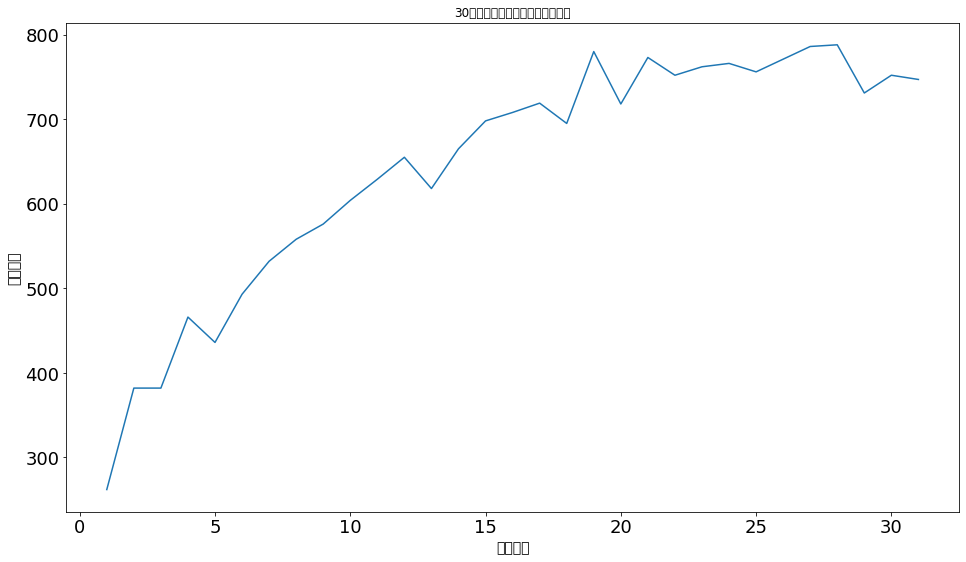

In [137]:
plt.figure(figsize=(16,9))
user_active_level.plot(title='30天内访问次数与访问人数的关系',fontsize=18)
plt.ylabel('访问人数',fontsize=14)
plt.xlabel('访问次数',fontsize=14)

上图可知，访问次数多的访客比访问次数少的访客数量多，且在20次左右为拐点，因此定义访问次数小于等于18次的为低活跃度，访问次数大于18次定义为高活跃度。
该图中，访问次数多的客户比访问次数少的客户数量多，与绝大多数产品访问规律相反。从侧面反映了淘宝的用户粘性强。


In [138]:
labels['user_active_level'] = '高'
labels.loc[labels['counts_30_active']<=18,'user_active_level'] = '低'

## 购买活跃度

In [139]:
buy_active_level = labels['counts_30_buy'].value_counts().sort_index(ascending=False)

Text(0.5, 0, '购买次数')

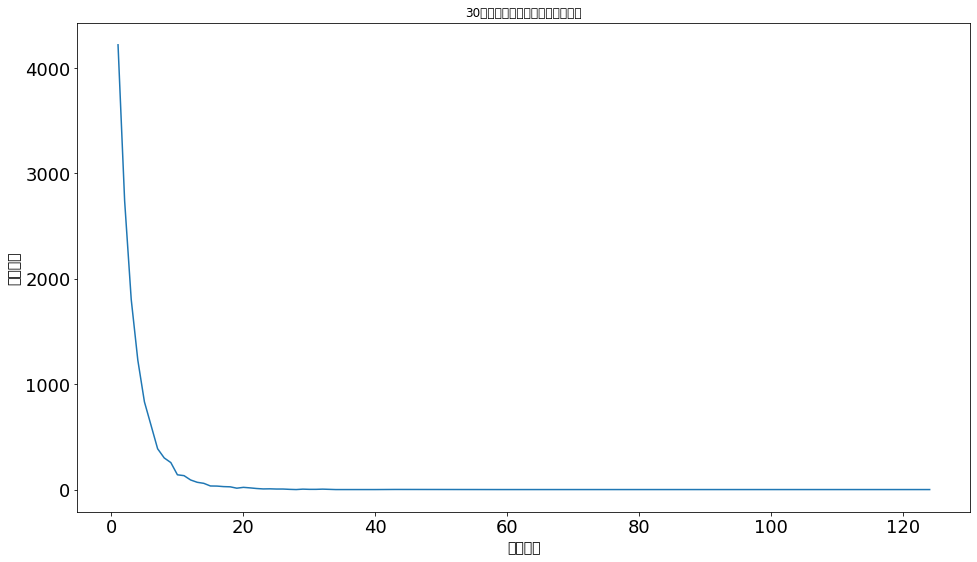

In [140]:
plt.figure(figsize=(16,9))
buy_active_level.plot(title='30天内购买次数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('购买次数',fontsize=14)

14次左右是一个拐点，因此定义购买次数小于等于14次为低活跃，大于14次为高活跃。
此定义只是从用户的角度触发，工作中当从业务出发定义是否活跃

In [141]:
labels['buy_active_level'] = '高'
labels.loc[labels['counts_30_buy']<=14,'buy_active_level'] = '低'

## 购买的品类是否单一

In [142]:
buy_single = df[df['behavior_type']==4].groupby('user_id').item_category.nunique().reset_index()

In [143]:
buy_single.rename(columns={'item_category':'buy_single'},inplace=True)

In [144]:
labels = pd.merge(labels,buy_single,how='left',on='user_id')

In [145]:
labels['buy_single'].fillna(-1,inplace=True)

In [146]:
labels['buy_single'] = labels['buy_single'].apply(lambda x: '是' if x>1 else  '否' if x==1 else '未购买' )

In [147]:
labels.head()

,user_id,time_browse,time_buy,week_browse,week_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,...,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single
0,63995000,晚上,晚上,7,6,6000,NaN,"2656,3472,10431,11834",9614,1.0,...,3.0,2.0,6.0,NaN,是,是,否,低,低,否
1,141227570,下午,上午,3,3,5232,"6344,6541",6936,6344,1.0,...,1.0,2.0,9.0,NaN,是,是,否,高,低,否
2,104574739,晚上,中午,2,7,1863,NaN,"3660,10894,11824","8029,9319",2.0,...,1.0,3.0,12.0,NaN,是,是,是,高,低,是
3,112700668,晚上,下午,1,5,1863,NaN,NaN,9517,1.0,...,1.0,NaN,14.0,NaN,是,否,否,高,低,否
4,53139833,晚上,"下午,晚上",7,3,5399,5399,"5232,5399,6255,10661",3988,4.0,...,1.0,8.0,1.0,10.0,是,是,是,高,低,是


## 用户价值分组（RFM）

In [148]:
last_buy_days = labels['days_buy'].value_counts().sort_index()

Text(0.5, 0, '距今天数')

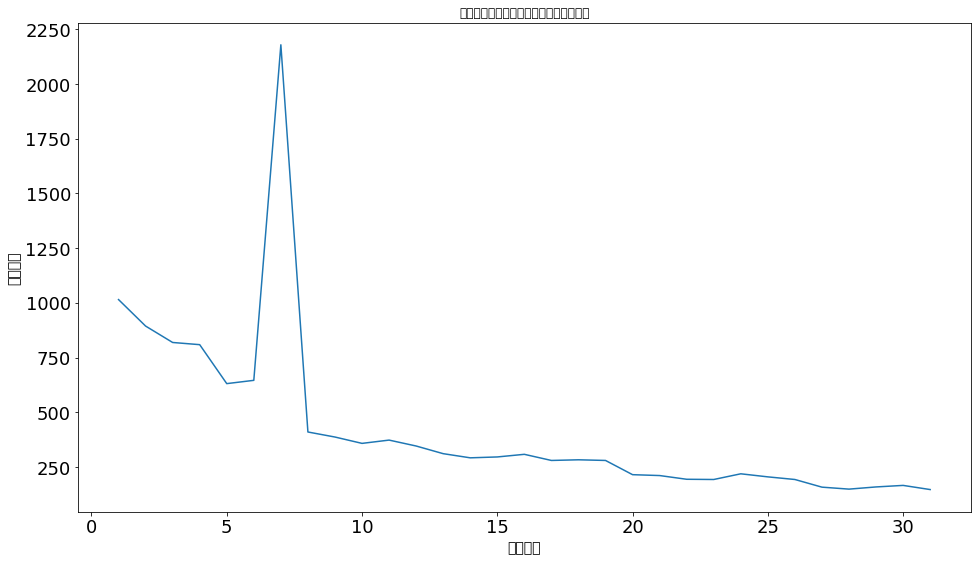

In [149]:
plt.figure(figsize=(16,9))
last_buy_days.plot(title='最后一次购买距今天数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('距今天数',fontsize=14)

ps:异常点为双12

In [151]:
labels['buy_days_level'] = '高'
labels.loc[labels['days_buy']>8,'buy_days_level'] = '低'

In [152]:
labels['rfm_value'] = labels['buy_active_level'].str.cat(labels['buy_days_level'])

因为没有消费金额特征，所以这里只最近一次交易和交易频率两个维度分析

In [153]:
def trans_value(x):
    if x == '高高':
        return '重要价值客户'
    elif x == '低高':
        return '重要深耕客户'
    elif x == '高低':
        return '重要唤回客户'
    else: 
        return '即将流失客户'

In [154]:
labels['rfm'] = labels['rfm_value'].apply(trans_value)

In [155]:
labels.drop(['buy_days_level','rfm_value'],axis=1,inplace=True)

In [156]:
labels['rfm'].value_counts()

重要深耕客户    7170
重要价值客户    7067
即将流失客户    5708
重要唤回客户      15
Name: rfm, dtype: int64

In [157]:
labels.head()

,user_id,time_browse,time_buy,week_browse,week_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,...,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single,rfm
0,63995000,晚上,晚上,7,6,6000,NaN,"2656,3472,10431,11834",9614,1.0,...,2.0,6.0,NaN,是,是,否,低,低,否,重要深耕客户
1,141227570,下午,上午,3,3,5232,"6344,6541",6936,6344,1.0,...,2.0,9.0,NaN,是,是,否,高,低,否,即将流失客户
2,104574739,晚上,中午,2,7,1863,NaN,"3660,10894,11824","8029,9319",2.0,...,3.0,12.0,NaN,是,是,是,高,低,是,即将流失客户
3,112700668,晚上,下午,1,5,1863,NaN,NaN,9517,1.0,...,NaN,14.0,NaN,是,否,否,高,低,否,即将流失客户
4,53139833,晚上,"下午,晚上",7,3,5399,5399,"5232,5399,6255,10661",3988,4.0,...,8.0,1.0,10.0,是,是,是,高,低,是,重要深耕客户
